<a href="https://colab.research.google.com/github/kotosham/sleep-stages/blob/main/MODELS_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and install libraries

In [1]:
! pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 57.5 MB/s eta 0:00:00


In [2]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import os
import random

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import ConcatDataset

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score

# Initialization

Data

In [3]:
#columns_to_read = ['1 LDF', '1 T', 'Sleep stages']
columns_to_read = ['1 LDF', 'Sleep stages']
columns_dtype = {
    columns_to_read[0]:  'float32',
    columns_to_read[-1]: 'int16',
 }

t_lower_bound = 35
big_file_no = 3
L_lower_threshold = 0
L_upper_threshold = 60
t_lower_threshold = 34

# Dictionary to map strings to integers
replacement_dict = {
    'W' : 0,
    'N2': 1,
    'N3': 1,
    'R' : 1
}

fragment_length = 900
num_samples = 10000
batch_size = 50
num_folds = 6
label_smoothing = 0.3

Model

In [4]:
num_features = len(columns_to_read) - 1
num_classes = 2

# Initialize the model
input_size = fragment_length * num_features  # Assuming 2 features per fragment
hidden_size = 50

lr = 0.001
n_epochs = 5

# Supplementary functions

Pre-processing of table data

In [5]:
def df_clean(df, replacement_dict, columns_to_read=columns_to_read):
  # delete rows with nan values in a column
  df = df.dropna()
  # LDF
  df = df[df[columns_to_read[0]] > L_lower_threshold]
  df = df[df[columns_to_read[0]] < L_upper_threshold]
  # Temperature
  #df = df[df[columns_to_read[1]] > t_lower_threshold]
  # the last column is for labels
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)
  return df

def change_dtypes(df, columns_dtype):
  df = df.astype(columns_dtype)
  return df

In [6]:
def plot_batch_features(features, targets, batch_idx):
    """
    Plots the features of a batch and uses the labels as captions.

    Args:
        features (torch.Tensor): The features tensor of shape (batch_size, num_features).
        targets (torch.Tensor): The targets tensor of shape (batch_size,).
        batch_idx (int): The index of the batch.
    """
    batch_size = features.shape[0]
    num_features = features.shape[1]

    fig, axes = plt.subplots(1, batch_size, figsize=(3 * batch_size, 3))

    if batch_size == 1:
        axes = [axes]  # Ensure axes is a list if batch_size is 1

    for i in range(batch_size):
        ax = axes[i]
        ax.plot(features[i].cpu().numpy())
        ax.set_title(f'Batch {batch_idx + 1}, Sample {i + 1}, Label: {targets[i].item()}')
        ax.set_xlabel('Feature Index')
        ax.set_ylabel('Feature Value')

    plt.tight_layout()
    plt.show()

In [7]:
def vis_data(df, columns_to_read=columns_to_read):
    num_columns = len(columns_to_read)
    fig, axes = plt.subplots(1, num_columns * 2, figsize=(15, 3))

    for k, column in enumerate(columns_to_read):
        # Гистограмма с KDE
        sns.histplot(df[column], kde=True, ax=axes[k * 2])
        axes[k * 2].set_title(f'Distribution of {column}')
        axes[k * 2].set_xlabel(column)
        axes[k * 2].set_ylabel('Frequency')

        # Диаграмма рассеяния
        sns.scatterplot(x=df.index, y=df[column], ax=axes[k * 2 + 1])
        axes[k * 2 + 1].set_title(f'Values of {column}')
        axes[k * 2 + 1].set_xlabel('Sample ID')
        axes[k * 2 + 1].set_ylabel(column)

    plt.tight_layout()
    plt.show()

# Download data

In [8]:
# GitHub repository URL
repo_url = "https://github.com/kotosham/sleep-stages"

# Raw files URLs
download_files = ['1.csv', '2.csv', '3-1.csv', '3-2.csv',
                  '4.csv', '5.csv', '6.csv', '7.csv']
# files_with_subfiles = ['3']

for i in download_files:
  file_url = f"{repo_url}/raw/main/{i}"
  # Download the file
  response = requests.get(file_url)
  # Check if the request was successful
  if response.status_code == 200:
      # Save the content to a local file
      with open(i, "wb") as file:
          file.write(response.content)
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")

Concatinate parts of a big file

In [9]:
dfs = []
df_3_1 = pd.read_csv('3-1.csv', usecols=columns_to_read)
dfs.append(df_3_1)
df_3_2 = pd.read_csv('3-2.csv', usecols=columns_to_read)
dfs.append(df_3_2)
df3 = pd.concat(dfs, ignore_index=True)
df3 = df_clean(df3,replacement_dict=replacement_dict)
df3 = change_dtypes(df3, columns_dtype)
print(df3.head())

       1 LDF  Sleep stages
0  20.400000             0
1  20.400000             0
2  20.400000             0
3  20.400000             0
4  17.200001             0


<ipython-input-5-471de14997d0>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


Collect all the files into a list of data frames

In [10]:
num_volunteers = (len(download_files) - 1)
files = [1]*num_volunteers
for i in range(num_volunteers):
  if i + 1 != big_file_no:
    print(i)
    f"{repo_url}/raw/main/{i}"
    files[i] = pd.read_csv(f"{i+1}.csv", usecols=columns_to_read)
    files[i] = df_clean(files[i],replacement_dict=replacement_dict)
    files[i] = change_dtypes(files[i], columns_dtype)
files[big_file_no - 1] = df3

0


<ipython-input-5-471de14997d0>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


1


<ipython-input-5-471de14997d0>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


3


<ipython-input-5-471de14997d0>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


4


<ipython-input-5-471de14997d0>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


5


<ipython-input-5-471de14997d0>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)
<ipython-input-10-1e9b2bb1580d>:7: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  files[i] = pd.read_csv(f"{i+1}.csv", usecols=columns_to_read)


6


<ipython-input-5-471de14997d0>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


Means and variances

In [11]:
alldf = pd.concat(files, axis=0)
features = alldf[columns_to_read[:-1]].values
means = features.mean(axis=0)
stds = features.std(axis=0)
del[alldf, features]
means, stds

(array([24.319523], dtype=float32), array([4.7959146], dtype=float32))

Visualize all the files

Volunteer 1
Number of samples 167591


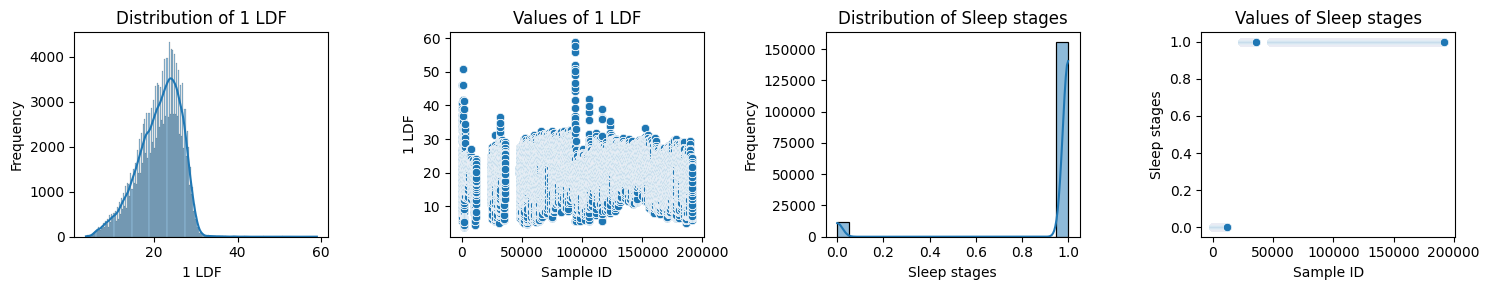

Volunteer 2
Number of samples 112882


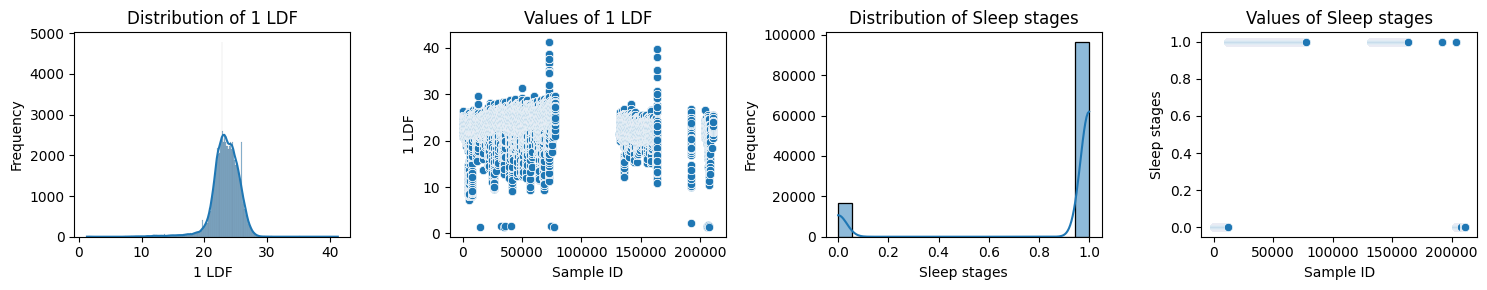

Volunteer 3
Number of samples 412168


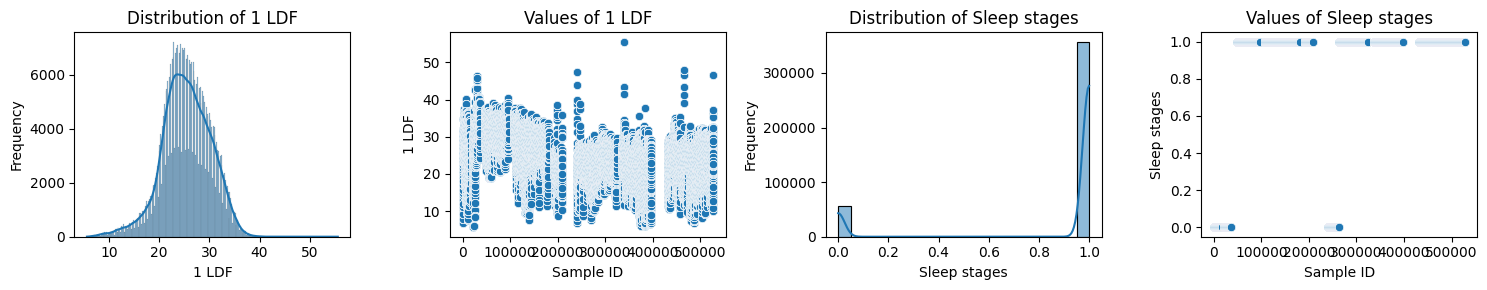

Volunteer 4
Number of samples 101936


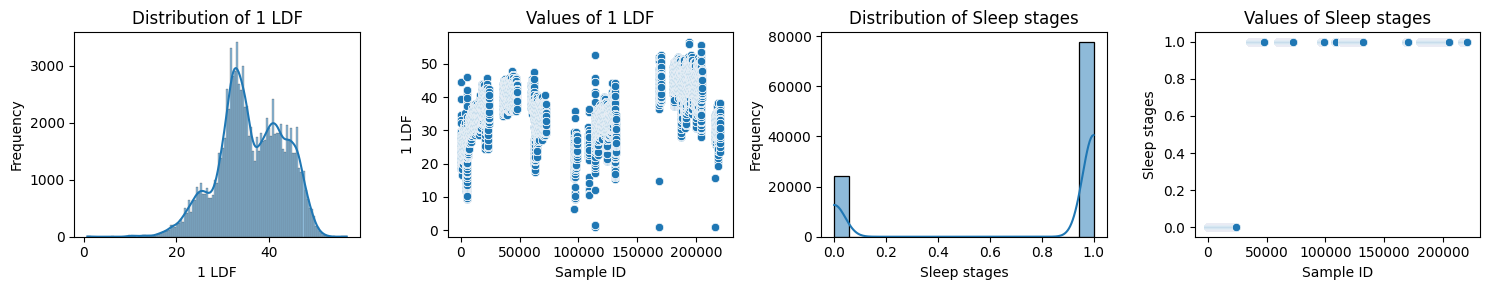

Volunteer 5
Number of samples 366627


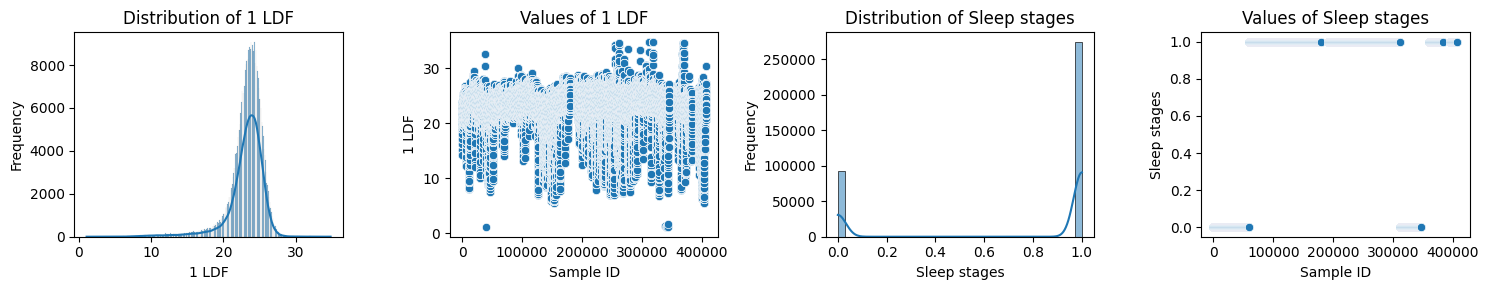

Volunteer 6
Number of samples 391025


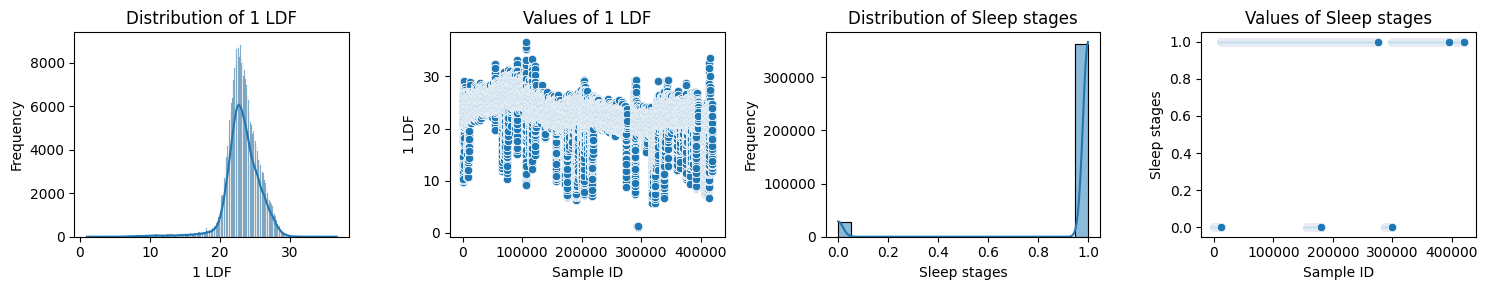

Volunteer 7
Number of samples 390871


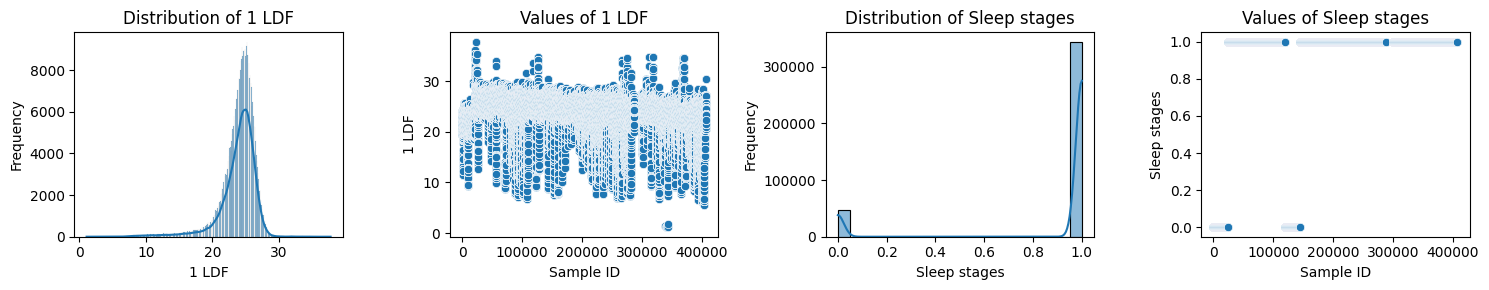

In [ ]:
for i in range(num_volunteers):
  print(f'Volunteer {i+1}')
  print(f'Number of samples {len(files[i])}')
  vis_data(files[i])

In [12]:
files[1]

,1 LDF,Sleep stages
0,22.200001,0
1,22.200001,0
2,22.200001,0
3,24.500000,0
4,24.500000,0
...,...,...
211019,24.000000,0
211020,24.000000,0
211021,23.900000,0
211022,23.900000,0


# Dataset, dataloader, model, and training procedure

In [13]:
class FragmentDataset(Dataset):
    def __init__(self, dataframe, fragment_length, means, stds, num_samples):
        self.dataframe = dataframe
        #self.dataframe = dataframe.sort_values(by=dataframe.columns[-1])  # Sort by class
        self.fragment_length = fragment_length
        self.means = means
        self.stds = stds
        self.num_samples = num_samples
        self.data = self.load_data()

    def load_data(self):
        data = []
        class_column = self.dataframe.columns[-1]
        unique_classes = self.dataframe[class_column].unique()

        for _ in range(self.num_samples):
            selected_class = random.choice(unique_classes)
            class_data = self.dataframe[self.dataframe[class_column] == selected_class]
            if len(class_data) < self.fragment_length:
                continue  # Пропускаем, если недостаточно данных для фрагмента

            start_idx = random.randint(0, len(class_data) - self.fragment_length)
            fragment = class_data.iloc[start_idx:start_idx + self.fragment_length].values
            fragment = (fragment[:, :-1] - self.means) / self.stds
            fragment = fragment.flatten(order='F')  # Flatten the fragment to 1D
            fragment = torch.tensor(fragment, dtype=torch.float32)
            label = torch.tensor(int(selected_class), dtype=torch.long)
            fragment = fragment.flatten()
            data.append((fragment, label))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        fragment, label = self.data[idx]
        return fragment, label


class FragmentDataModule(pl.LightningDataModule):
    def __init__(self, files, means, stds, fragment_length=fragment_length, num_samples=num_samples, batch_size=batch_size, num_folds=num_folds):
        self.files = files
        self.fragment_length = fragment_length
        self.means = means
        self.stds = stds
        self.num_samples = num_samples
        self.batch_size = batch_size
        self.num_folds = num_folds

    def setup(self, stage=None):
        self.datasets = [FragmentDataset(df, self.fragment_length, self.means, self.stds, self.num_samples) for df in self.files]
        self.kfold = KFold(n_splits=self.num_folds)

    def train_dataloader(self, train_indices):
        train_datasets = [self.datasets[i] for i in train_indices]
        return DataLoader(torch.utils.data.ConcatDataset(train_datasets), batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self, val_indices):
        val_datasets = [self.datasets[i] for i in val_indices]
        return DataLoader(torch.utils.data.ConcatDataset(val_datasets), batch_size=self.batch_size)

    def test_dataloader(self, test_index):
        test_dataset = self.datasets[test_index]
        return DataLoader(test_dataset, batch_size=self.batch_size)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

class MLPModel(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_classes, class_weights=None, label_smoothing=0.0):
        super(MLPModel, self).__init__()
        self.model = MLP(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)

        if class_weights is not None:
            self.criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smoothing)
        else:
            self.criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)

        loss = self.criterion(outputs, y)

        preds = torch.argmax(outputs, dim=1)

        acc = accuracy_score(y.cpu(), preds.cpu())

        self.log('train_loss', loss)
        self.log('train_acc', acc)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)

        loss = self.criterion(outputs, y)
        preds = torch.argmax(outputs, dim=1)
        acc = accuracy_score(y.cpu(), preds.cpu())

        self.log('val_loss', loss)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.criterion(outputs, y)

        self.log('test_loss', loss)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=lr)

# Бинарная классификация

In [14]:
data_module = FragmentDataModule(files, means, stds)
data_module.setup()

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
test_accuracies = []

param_grid = {
    'n_estimators': [50],
    'max_depth': [7],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['log2'],
    'criterion': ['entropy']
}


for fold, (train_indices, val_indices) in enumerate(data_module.kfold.split(range(len(data_module.datasets)-1))):
    print(f'Fold {fold + 1}')

    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_indices)

    X_train, y_train = [], []
    for batch in train_loader:
        features, labels = batch
        X_train.append(features.numpy())
        y_train.append(labels.numpy())

    X_train = np.vstack(X_train)
    y_train = np.concatenate(y_train)

    X_val, y_val = [], []
    for batch in val_loader:
        features, labels = batch
        X_val.append(features.numpy())
        y_val.append(labels.numpy())

    X_val = np.vstack(X_val)
    y_val = np.concatenate(y_val)

    model_rf = RandomForestClassifier(n_jobs=-1)
    grid_search = GridSearchCV(model_rf, param_grid, cv=3)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    val_preds = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)

    print(f'Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}')

    test_index = len(data_module.datasets) - 1

    test_loader = data_module.test_dataloader(test_index)

    X_test, y_test = [], []
    for batch in test_loader:
        features, labels = batch
        X_test.append(features.numpy())
        y_test.append(labels.numpy())

    X_test = np.vstack(X_test)
    y_test = np.concatenate(y_test)

    test_preds = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_accuracies.append(test_accuracy)

    print(f'Test Accuracy for Fold {fold + 1}: {test_accuracy:.4f}')

mean_test_accuracy = np.mean(test_accuracies)
print(f'Mean Test Accuracy: {mean_test_accuracy:.4f}')

Fold 1
Validation Accuracy for Fold 1: 0.6681
Test Accuracy for Fold 1: 0.6014
Fold 2
Validation Accuracy for Fold 2: 0.7763
Test Accuracy for Fold 2: 0.6070
Fold 3
Validation Accuracy for Fold 3: 0.5641
Test Accuracy for Fold 3: 0.6147
Fold 4
Validation Accuracy for Fold 4: 0.3963
Test Accuracy for Fold 4: 0.6136
Fold 5
Validation Accuracy for Fold 5: 0.5977
Test Accuracy for Fold 5: 0.6075
Fold 6
Validation Accuracy for Fold 6: 0.5564
Test Accuracy for Fold 6: 0.6243
Mean Test Accuracy: 0.6114


### SVM model

In [15]:
from sklearn.svm import SVC

In [16]:
test_accuracies = []

for fold, (train_indices, val_indices) in enumerate(data_module.kfold.split(range(len(data_module.datasets)-1))):
    print(f'Fold {fold + 1}')

    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_indices)

    X_train, y_train = [], []
    for batch in train_loader:
        features, labels = batch
        X_train.append(features.numpy())
        y_train.append(labels.numpy())

    X_train = np.vstack(X_train)
    y_train = np.concatenate(y_train)

    X_val, y_val = [], []
    for batch in val_loader:
        features, labels = batch
        X_val.append(features.numpy())
        y_val.append(labels.numpy())

    X_val = np.vstack(X_val)
    y_val = np.concatenate(y_val)

    model_svm = SVC(kernel='rbf', C=1.0, gamma='scale')

    model_svm.fit(X_train, y_train)

    val_preds = model_svm.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)

    print(f'Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}')

    test_index = len(data_module.datasets) - 1

    test_loader = data_module.test_dataloader(test_index)

    X_test, y_test = [], []
    for batch in test_loader:
        features, labels = batch
        X_test.append(features.numpy())
        y_test.append(labels.numpy())

    X_test = np.vstack(X_test)
    y_test = np.concatenate(y_test)

    test_preds = model_svm.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_accuracies.append(test_accuracy)

    print(f'Test Accuracy for Fold {fold + 1}: {test_accuracy:.4f}')

mean_test_accuracy = np.mean(test_accuracies)
print(f'Mean Test Accuracy: {mean_test_accuracy:.4f}')

Fold 1
Validation Accuracy for Fold 1: 0.5286
Test Accuracy for Fold 1: 0.5769
Fold 2
Validation Accuracy for Fold 2: 0.6914
Test Accuracy for Fold 2: 0.6225
Fold 3
Validation Accuracy for Fold 3: 0.5707
Test Accuracy for Fold 3: 0.6346
Fold 4
Validation Accuracy for Fold 4: 0.4019
Test Accuracy for Fold 4: 0.6104
Fold 5
Validation Accuracy for Fold 5: 0.5942
Test Accuracy for Fold 5: 0.6263
Fold 6
Validation Accuracy for Fold 6: 0.5510
Test Accuracy for Fold 6: 0.6426
Mean Test Accuracy: 0.6189


### MLP model

In [ ]:
test_accuracies = []

for fold, (train_indices, val_index) in enumerate(data_module.kfold.split(range(len(data_module.datasets)-1))):
    print(f'Fold {fold + 1}')

    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_index)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    y_train = []
    for batch in train_loader:
        _, labels = batch
        y_train.extend(labels.numpy())

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

    model_mlp = MLPModel(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes, class_weights=class_weights_tensor,label_smoothing=label_smoothing)
    model_mlp.to(device)

    logger = TensorBoardLogger("logs", name="mlp_model")
    trainer = Trainer(max_epochs=n_epochs, callbacks=[ModelCheckpoint(monitor='val_loss')], logger=logger)

    trainer.fit(model_mlp, train_dataloaders=train_loader, val_dataloaders=val_loader)

    val_acc = trainer.callback_metrics['val_acc'].item()
    print(f'Validation Accuracy for Fold {fold + 1}: {val_acc:.4f}')

    test_index = len(data_module.datasets)-1
    test_loader = data_module.test_dataloader(test_index)

    # Load the best model for this fold
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = MLPModel.load_from_checkpoint(best_model_path,
                                               input_size=input_size,
                                               hidden_size=hidden_size,
                                               num_classes=num_classes,
                                               strict=False)
    best_model.to(device)

    y_true = []
    y_pred = []

    for batch in test_loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        outputs = best_model(x)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(y.tolist())
        y_pred.extend(preds.tolist())
        #print(f'Predictions: {preds.cpu().numpy()}')
        #print(f'True Labels: {y.tolist()}')

    accuracy = accuracy_score(y_true, y_pred)
    test_accuracies.append(accuracy)
    print(f'Test Accuracy for Fold {fold + 1}: {accuracy:.4f}')

mean_test_accuracy = np.mean(test_accuracies)
print(f'Mean Test Accuracy: {mean_test_accuracy:.4f}')

Fold 1


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 45.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
45.2 K    Trainable params
0         Non-trainable params
45.2 K    Total params
0.181     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.weight']


Validation Accuracy for Fold 1: 0.6697
Test Accuracy for Fold 1: 0.6146
Fold 2


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 45.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
45.2 K    Trainable params
0         Non-trainable params
45.2 K    Total params
0.181     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.weight']


Validation Accuracy for Fold 2: 0.6303
Test Accuracy for Fold 2: 0.6435
Fold 3


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 45.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
45.2 K    Trainable params
0         Non-trainable params
45.2 K    Total params
0.181     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.weight']


Validation Accuracy for Fold 3: 0.5812
Test Accuracy for Fold 3: 0.6096
Fold 4


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 45.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
45.2 K    Trainable params
0         Non-trainable params
45.2 K    Total params
0.181     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.weight']


Validation Accuracy for Fold 4: 0.4203
Test Accuracy for Fold 4: 0.6292
Fold 5


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 45.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
45.2 K    Trainable params
0         Non-trainable params
45.2 K    Total params
0.181     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.weight']


Validation Accuracy for Fold 5: 0.5704
Test Accuracy for Fold 5: 0.6238
Fold 6


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 45.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
45.2 K    Trainable params
0         Non-trainable params
45.2 K    Total params
0.181     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.weight']


Validation Accuracy for Fold 6: 0.4837
Test Accuracy for Fold 6: 0.6674
Mean Test Accuracy: 0.6313


### Gradient Boosting

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
test_accuracies = []

for fold, (train_indices, val_indices) in enumerate(data_module.kfold.split(range(len(data_module.datasets)-1))):
    print(f'Fold {fold + 1}')

    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_indices)

    X_train, y_train = [], []
    for batch in train_loader:
        features, labels = batch
        X_train.append(features.numpy())
        y_train.append(labels.numpy())

    X_train = np.vstack(X_train)
    y_train = np.concatenate(y_train)

    X_val, y_val = [], []
    for batch in val_loader:
        features, labels = batch
        X_val.append(features.numpy())
        y_val.append(labels.numpy())

    X_val = np.vstack(X_val)
    y_val = np.concatenate(y_val)

    model_gb = XGBClassifier(
                            n_estimators=300,
                            learning_rate=lr,
                            max_depth=5,
                            random_state=42,
                            tree_method='gpu_hist'
                            )

    model_gb.fit(X_train, y_train)

    val_preds = model_gb.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)

    print(f'Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}')

    test_index = len(data_module.datasets) - 1

    test_loader = data_module.test_dataloader(test_index)

    X_test, y_test = [], []
    for batch in test_loader:
        features, labels = batch
        X_test.append(features.numpy())
        y_test.append(labels.numpy())

    X_test = np.vstack(X_test)
    y_test = np.concatenate(y_test)

    test_preds = model_gb.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_accuracies.append(test_accuracy)

    print(f'Test Accuracy for Fold {fold + 1}: {test_accuracy:.4f}')

mean_test_accuracy = np.mean(test_accuracies)
print(f'Mean Test Accuracy: {mean_test_accuracy:.4f}')

Fold 1


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:18:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:18:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Fold 1: 0.7294
Test Accuracy for Fold 1: 0.6029
Fold 2


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:18:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:18:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Fold 2: 0.7452
Test Accuracy for Fold 2: 0.5760
Fold 3


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:18:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:19:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Fold 3: 0.5457
Test Accuracy for Fold 3: 0.6116
Fold 4


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:19:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:19:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Fold 4: 0.4091
Test Accuracy for Fold 4: 0.6167
Fold 5


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:19:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:19:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Fold 5: 0.5825
Test Accuracy for Fold 5: 0.6115
Fold 6


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:19:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:19:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Fold 6: 0.5614
Test Accuracy for Fold 6: 0.6234
Mean Test Accuracy: 0.6070


# Многоклассовая классификация

In [ ]:
replacement_dict = {
    'W': 0,
    'N2': 1,
    'N3': 1,
    'R': 2
}

num_classes = 3

In [ ]:
dfs = []
df_3_1 = pd.read_csv('3-1.csv', usecols=columns_to_read)
dfs.append(df_3_1)
df_3_2 = pd.read_csv('3-2.csv', usecols=columns_to_read)
dfs.append(df_3_2)
df3 = pd.concat(dfs, ignore_index=True)
df3 = df_clean(df3, replacement_dict=replacement_dict)
df3 = change_dtypes(df3, columns_dtype)

files = [1]*num_volunteers
for i in range(num_volunteers):
  if i + 1 != big_file_no:
    print(i)
    f"{repo_url}/raw/main/{i}"
    files[i] = pd.read_csv(f"{i+1}.csv", usecols=columns_to_read)
    files[i] = df_clean(files[i], replacement_dict=replacement_dict)
    files[i] = change_dtypes(files[i], columns_dtype)
files[big_file_no - 1] = df3

<ipython-input-4-471de14997d0>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)
<ipython-input-4-471de14997d0>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


0
1


<ipython-input-4-471de14997d0>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)
<ipython-input-4-471de14997d0>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


3
4


<ipython-input-4-471de14997d0>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


5


<ipython-input-4-471de14997d0>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)
<ipython-input-53-2e6a992e9745>:15: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  files[i] = pd.read_csv(f"{i+1}.csv", usecols=columns_to_read)


6


<ipython-input-4-471de14997d0>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


Volunteer 1
Number of samples 167591


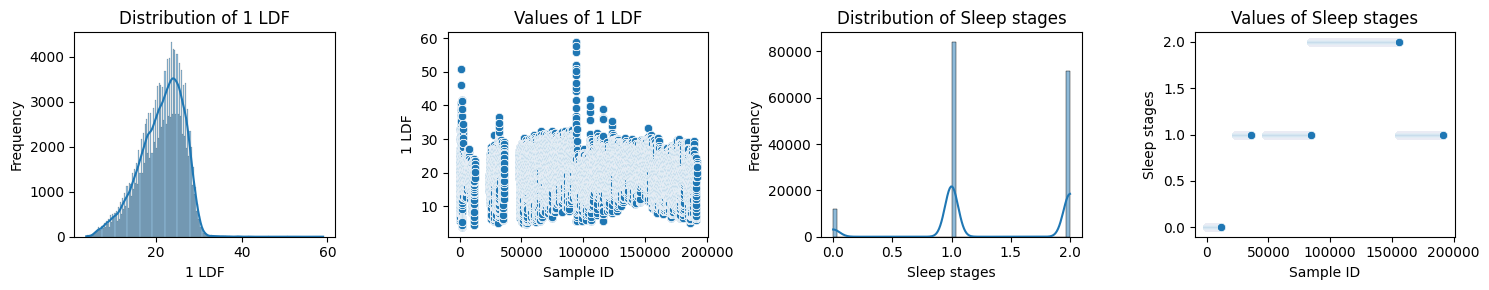

Volunteer 2
Number of samples 112882


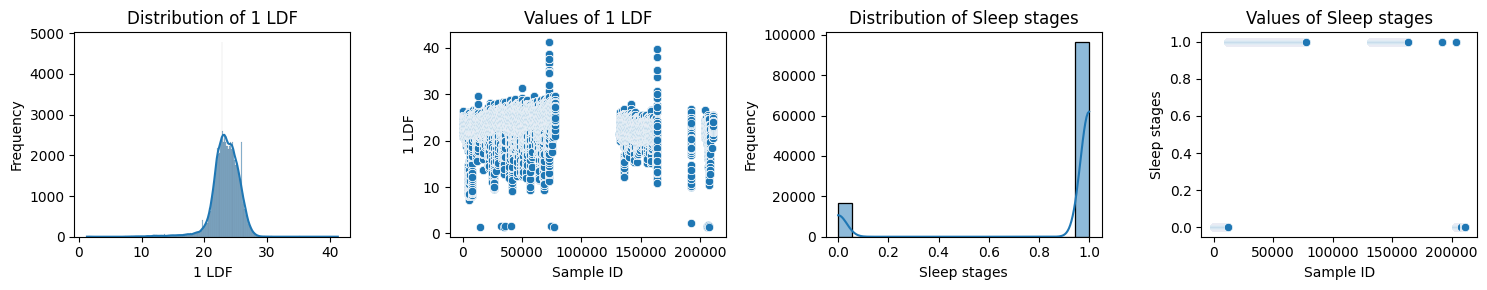

Volunteer 3
Number of samples 412168


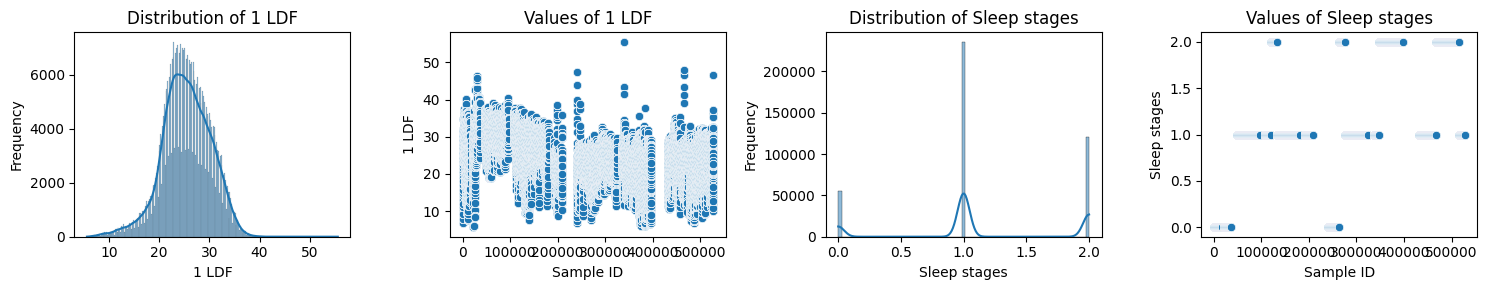

Volunteer 4
Number of samples 101936


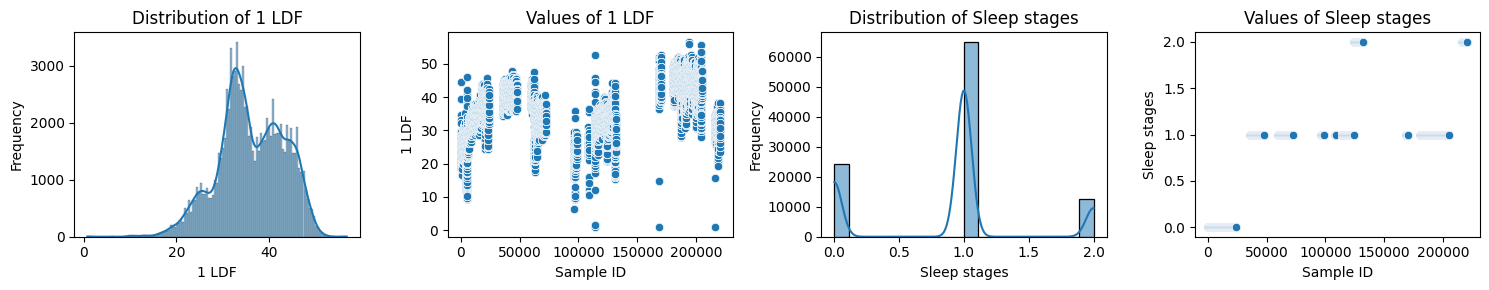

Volunteer 5
Number of samples 366627


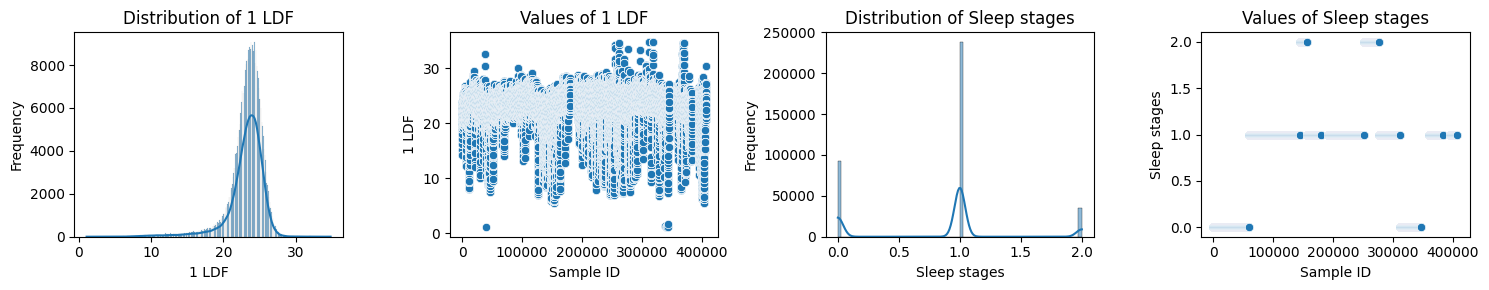

Volunteer 6
Number of samples 391025


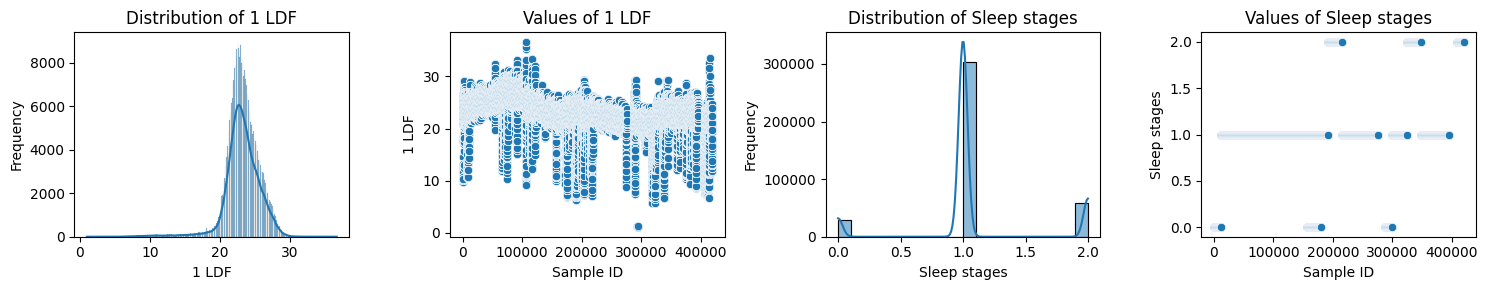

Volunteer 7
Number of samples 390871


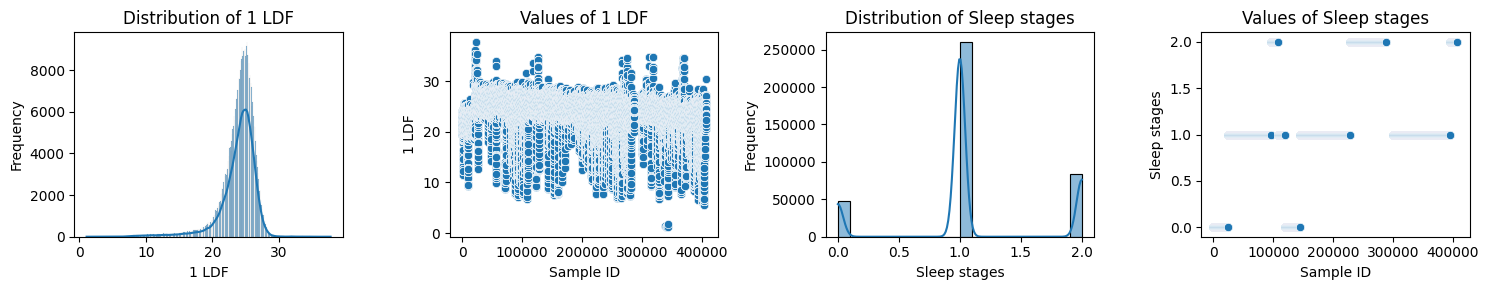

In [ ]:
for i in range(num_volunteers):
  print(f'Volunteer {i+1}')
  print(f'Number of samples {len(files[i])}')
  vis_data(files[i])

In [ ]:
data_module = FragmentDataModule(files,means,stds)
data_module.setup()

### Random Forest

In [ ]:
test_accuracies = []

param_grid = {
    'n_estimators': [100],
    'max_depth': [5],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'criterion': ['gini']
}


for fold, (train_indices, val_indices) in enumerate(data_module.kfold.split(range(len(data_module.datasets)-1))):
    print(f'Fold {fold + 1}')

    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_indices)

    X_train, y_train = [], []
    for batch in train_loader:
        features, labels = batch
        X_train.append(features.numpy())
        y_train.append(labels.numpy())

    X_train = np.vstack(X_train)
    y_train = np.concatenate(y_train)

    X_val, y_val = [], []
    for batch in val_loader:
        features, labels = batch
        X_val.append(features.numpy())
        y_val.append(labels.numpy())

    X_val = np.vstack(X_val)
    y_val = np.concatenate(y_val)

    model_rf = RandomForestClassifier(n_jobs=-1)
    grid_search = GridSearchCV(model_rf, param_grid, cv=3)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    val_preds = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)

    print(f'Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}')

    test_index = len(data_module.datasets) - 1

    test_loader = data_module.test_dataloader(test_index)

    X_test, y_test = [], []
    for batch in test_loader:
        features, labels = batch
        X_test.append(features.numpy())
        y_test.append(labels.numpy())

    X_test = np.vstack(X_test)
    y_test = np.concatenate(y_test)

    test_preds = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_accuracies.append(test_accuracy)

    print(f'Test Accuracy for Fold {fold + 1}: {test_accuracy:.4f}')

mean_test_accuracy = np.mean(test_accuracies)
print(f'Mean Test Accuracy: {mean_test_accuracy:.4f}')

Fold 1
Validation Accuracy for Fold 1: 0.2855
Test Accuracy for Fold 1: 0.4484
Fold 2
Validation Accuracy for Fold 2: 0.7535
Test Accuracy for Fold 2: 0.4830
Fold 3
Validation Accuracy for Fold 3: 0.2862
Test Accuracy for Fold 3: 0.4155
Fold 4
Validation Accuracy for Fold 4: 0.2575
Test Accuracy for Fold 4: 0.4209
Fold 5
Validation Accuracy for Fold 5: 0.3874
Test Accuracy for Fold 5: 0.4077
Fold 6
Validation Accuracy for Fold 6: 0.4059
Test Accuracy for Fold 6: 0.4130
Mean Test Accuracy: 0.4314


### SVM

In [ ]:
test_accuracies = []

for fold, (train_indices, val_indices) in enumerate(data_module.kfold.split(range(len(data_module.datasets)-1))):
    print(f'Fold {fold + 1}')

    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_indices)

    X_train, y_train = [], []
    for batch in train_loader:
        features, labels = batch
        X_train.append(features.numpy())
        y_train.append(labels.numpy())

    X_train = np.vstack(X_train)
    y_train = np.concatenate(y_train)

    X_val, y_val = [], []
    for batch in val_loader:
        features, labels = batch
        X_val.append(features.numpy())
        y_val.append(labels.numpy())

    X_val = np.vstack(X_val)
    y_val = np.concatenate(y_val)

    model_svm = SVC(kernel='rbf', C=1.0, gamma='scale')

    model_svm.fit(X_train, y_train)

    val_preds = model_svm.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)

    print(f'Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}')

    test_index = len(data_module.datasets) - 1

    test_loader = data_module.test_dataloader(test_index)

    X_test, y_test = [], []
    for batch in test_loader:
        features, labels = batch
        X_test.append(features.numpy())
        y_test.append(labels.numpy())

    X_test = np.vstack(X_test)
    y_test = np.concatenate(y_test)

    test_preds = model_svm.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_accuracies.append(test_accuracy)

    print(f'Test Accuracy for Fold {fold + 1}: {test_accuracy:.4f}')

mean_test_accuracy = np.mean(test_accuracies)
print(f'Mean Test Accuracy: {mean_test_accuracy:.4f}')

Fold 1
Validation Accuracy for Fold 1: 0.2650
Test Accuracy for Fold 1: 0.4300
Fold 2
Validation Accuracy for Fold 2: 0.6374
Test Accuracy for Fold 2: 0.4702
Fold 3
Validation Accuracy for Fold 3: 0.3428
Test Accuracy for Fold 3: 0.4350
Fold 4
Validation Accuracy for Fold 4: 0.2406
Test Accuracy for Fold 4: 0.4500
Fold 5
Validation Accuracy for Fold 5: 0.4230
Test Accuracy for Fold 5: 0.4330
Fold 6
Validation Accuracy for Fold 6: 0.4150
Test Accuracy for Fold 6: 0.4290
Mean Test Accuracy: 0.4412


### MLP

In [ ]:
test_accuracies = []

for fold, (train_indices, val_index) in enumerate(data_module.kfold.split(range(len(data_module.datasets)-1))):
    print(f'Fold {fold + 1}')

    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_index)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    y_train = []
    for batch in train_loader:
        _, labels = batch
        y_train.extend(labels.numpy())

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

    model_mlp = MLPModel(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes, class_weights=class_weights_tensor,label_smoothing=label_smoothing)
    model_mlp.to(device)

    logger = TensorBoardLogger("logs", name="mlp_model")
    trainer = Trainer(max_epochs=n_epochs, callbacks=[ModelCheckpoint(monitor='val_loss')], logger=logger)

    trainer.fit(model_mlp, train_dataloaders=train_loader, val_dataloaders=val_loader)

    val_acc = trainer.callback_metrics['val_acc'].item()
    print(f'Validation Accuracy for Fold {fold + 1}: {val_acc:.4f}')

    test_index = len(data_module.datasets)-1

    test_loader = data_module.test_dataloader(test_index)

    # Load the best model for this fold
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = MLPModel.load_from_checkpoint(best_model_path,
                                               input_size=input_size,
                                               hidden_size=hidden_size,
                                               num_classes=num_classes,
                                               strict=False)
    best_model.to(device)

    y_true = []
    y_pred = []

    for batch in test_loader:
        x, y = batch
        x = x.to(device)
        outputs = best_model(x)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(y.tolist())
        y_pred.extend(preds.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    test_accuracies.append(accuracy)
    print(f'Test Accuracy for Fold {fold + 1}: {accuracy:.4f}')

mean_test_accuracy = np.mean(test_accuracies)
print(f'Mean Test Accuracy: {mean_test_accuracy:.4f}')

Fold 1


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 45.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
45.2 K    Trainable params
0         Non-trainable params
45.2 K    Total params
0.181     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.weight']


Validation Accuracy for Fold 1: 0.3968
Test Accuracy for Fold 1: 0.5266
Fold 2


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 45.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
45.2 K    Trainable params
0         Non-trainable params
45.2 K    Total params
0.181     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.weight']


Validation Accuracy for Fold 2: 0.4397
Test Accuracy for Fold 2: 0.4566
Fold 3


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 45.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
45.2 K    Trainable params
0         Non-trainable params
45.2 K    Total params
0.181     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.weight']


Validation Accuracy for Fold 3: 0.4168
Test Accuracy for Fold 3: 0.5241
Fold 4


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 45.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
45.2 K    Trainable params
0         Non-trainable params
45.2 K    Total params
0.181     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.weight']


Validation Accuracy for Fold 4: 0.3229
Test Accuracy for Fold 4: 0.5287
Fold 5


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 45.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
45.2 K    Trainable params
0         Non-trainable params
45.2 K    Total params
0.181     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.weight']


Validation Accuracy for Fold 5: 0.4332
Test Accuracy for Fold 5: 0.5020
Fold 6


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 45.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
45.2 K    Trainable params
0         Non-trainable params
45.2 K    Total params
0.181     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.weight']


Validation Accuracy for Fold 6: 0.3591
Test Accuracy for Fold 6: 0.5167
Mean Test Accuracy: 0.5091


### Gradient Boosting

In [ ]:
test_accuracies = []

for fold, (train_indices, val_indices) in enumerate(data_module.kfold.split(range(len(data_module.datasets)-1))):
    print(f'Fold {fold + 1}')

    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_indices)

    X_train, y_train = [], []
    for batch in train_loader:
        features, labels = batch
        X_train.append(features.numpy())
        y_train.append(labels.numpy())

    X_train = np.vstack(X_train)
    y_train = np.concatenate(y_train)

    X_val, y_val = [], []
    for batch in val_loader:
        features, labels = batch
        X_val.append(features.numpy())
        y_val.append(labels.numpy())

    X_val = np.vstack(X_val)
    y_val = np.concatenate(y_val)

    model_gb = XGBClassifier(
                            n_estimators=300,
                            learning_rate=lr,
                            max_depth=5,
                            random_state=42,
                            tree_method='gpu_hist'
                            )

    model_gb.fit(X_train, y_train)

    val_preds = model_gb.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)

    print(f'Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}')

    test_index = len(data_module.datasets) - 1

    test_loader = data_module.test_dataloader(test_index)

    X_test, y_test = [], []
    for batch in test_loader:
        features, labels = batch
        X_test.append(features.numpy())
        y_test.append(labels.numpy())

    X_test = np.vstack(X_test)
    y_test = np.concatenate(y_test)

    test_preds = model_gb.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_accuracies.append(test_accuracy)

    print(f'Test Accuracy for Fold {fold + 1}: {test_accuracy:.4f}')

mean_test_accuracy = np.mean(test_accuracies)
print(f'Mean Test Accuracy: {mean_test_accuracy:.4f}')

Fold 1


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:48:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:49:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Fold 1: 0.2968
Test Accuracy for Fold 1: 0.4559
Fold 2


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:49:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:49:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Fold 2: 0.7299
Test Accuracy for Fold 2: 0.4487
Fold 3


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:49:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:49:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Fold 3: 0.3007
Test Accuracy for Fold 3: 0.4205
Fold 4


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:49:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:50:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Fold 4: 0.2508
Test Accuracy for Fold 4: 0.4603
Fold 5


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:50:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:50:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Fold 5: 0.3866
Test Accuracy for Fold 5: 0.4201
Fold 6


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:50:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:50:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Fold 6: 0.3907
Test Accuracy for Fold 6: 0.4277
Mean Test Accuracy: 0.4389
